<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

Was wird in diesem Notebook gemacht?

## Verbinden mit der Google Drive und Import der benötigten Module:

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

import matplotlib
import seaborn as sns

In [3]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [4]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [129]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

df_UVI.index = pd.to_datetime(df_UVI.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

In [6]:
df_UVI_hourly = df_UVI[['UVI','erythem', 'SolarZenithAngle']].resample('H').mean()

In [148]:
df_UVI, df_CAMS

(                     Unnamed: 0       Datum   Uhrzeit  Messzeitpunkt  \
 Datetime                                                               
 2022-06-15 07:21:00           0  2022-06-15  07:21:00        26460.0   
 2022-06-15 07:23:00           1  2022-06-15  07:23:00        26580.0   
 2022-06-15 07:25:00           2  2022-06-15  07:25:00        26700.0   
 2022-06-15 07:27:00           3  2022-06-15  07:27:00        26820.0   
 2022-06-15 07:29:00           4  2022-06-15  07:29:00        26940.0   
 ...                         ...         ...       ...            ...   
 2023-05-26 09:04:00      101736  2023-05-26  09:04:00        32640.0   
 2023-05-26 09:06:00      101737  2023-05-26  09:06:00        32760.0   
 2023-05-26 09:08:00      101738  2023-05-26  09:08:00        32880.0   
 2023-05-26 09:10:00      101739  2023-05-26  09:10:00        33000.0   
 2023-05-26 09:12:00      101740  2023-05-26  09:12:00        33120.0   
 
                       erythem       UVI  DiffGre

## Plotten der Dataframes:

### Plot der Tagesdurchschnitte:

In [7]:
def plot_daily_mean_data(df1, df2, value_column1='UVI', value_column2='Wert2'):

    # Resample auf tägliche Auflösung und Berechnung des Durchschnitts
    df1_daily = df1.resample('D').mean()
    df2_daily = df2.resample('D').mean()

    # Erstellen Sie den Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df1_daily.index, df1_daily[value_column1], label='DataFrame 1', marker='o')
    plt.plot(df2_daily.index, df2_daily[value_column2], label='DataFrame 2', marker='x')

    plt.title('Tägliche Messwerte')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnittlicher Messwert')
    plt.legend()
    plt.grid(True)

    # Rotieren Sie die X-Achsenbeschriftungen für bessere Lesbarkeit
    plt.xticks(rotation=45)

    # Zeigen Sie den Plot an
    plt.tight_layout()
    plt.show()

<ipython-input-7-8b9276a4edb2>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1_daily = df1.resample('D').mean()


KeyError: ignored

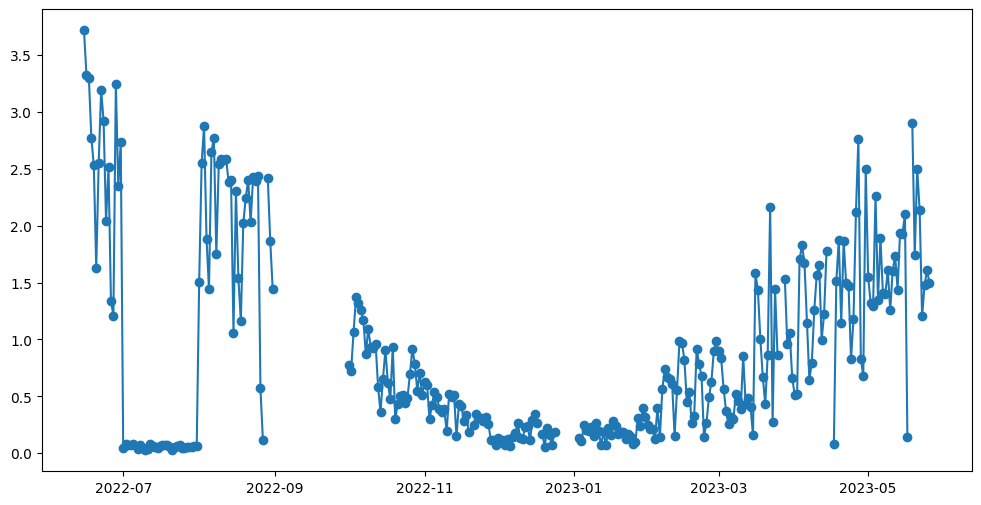

In [8]:
# plot_daily_mean_data(df_UVI, df_CAMS)

### Plot der täglichen Verläufe:

In [171]:
def plot_daily_data_and_save(df1, df2, output_dir, columns1, columns2):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Gruppieren Sie die DataFrames nach Tag und plotten Sie den Verlauf für jeden Tag in einem Plot
    for date, group1 in df1.groupby(df1.index.date):
        group2 = df2[df2.index.date == date]

        # Erstellen Sie den Plot für diesen Tag
        plt.figure(figsize=(10, 6))

        # Definieren Sie eine Liste von Farben für die Plots
        colors = sns.color_palette('husl', n_colors=len(columns1) + len(columns2))

        # Hinzufügen der Datenreihen aus DataFrame 1 mit eigenen Y-Achsen
        for i, col in enumerate(columns1):
            color = colors[i]
            sns.lineplot(data=group1, x=group1.index, y=col, label=f'{col}', color=color)
            if i == 0:
                ax1 = plt.gca()
                ax1.set_xlabel('Stunde')
                ax1.set_ylabel(f'{col}')
                ax1.grid(True)
            else:
                ax1_2 = ax1.twinx()
                ax1_2.set_ylabel(f'{col}')


        # Hinzufügen der Datenreihen aus DataFrame 2 mit eigenen Y-Achsen
        for i, col in enumerate(columns2):
            color = colors[i + len(columns1)]
            sns.lineplot(data=group2, x=group2.index, y=col, label=f'{col}', color=color)
            if i == 0:
                ax2 = ax1.twinx()
                ax2.set_ylabel(f'{col}')
            else:
                ax2_2 = ax1.twinx()
                ax2_2.set_ylabel(f'{col}')

        # Beschriftungen und Legende hinzufügen
        plt.title(f'Messwerte für {date}')
        plt.grid(True)
        # plt.legend(loc='upper right')

        plt.show()

        # Speichern Sie den Plot als Bild
        plot_filename = os.path.join(output_dir, f'plot_{date}.png')
        plt.savefig(plot_filename)
        plt.close()

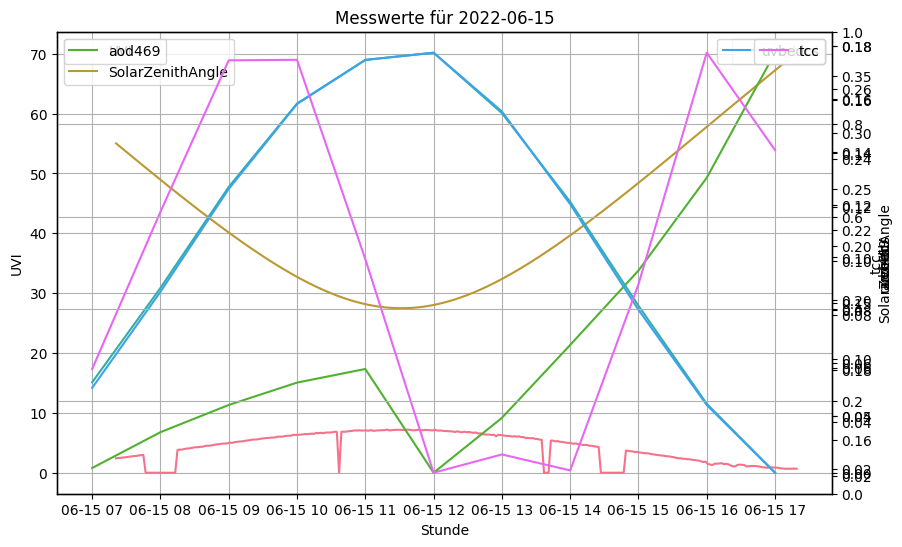

In [172]:
columns_UVI = ['UVI', 'SolarZenithAngle']  # Beispiel für Spalten aus df1
columns_CAMS = ['aod469', 'uvbed', 'uvbedcs', 'tcc']  # Beispiel für Spalten aus df2
plot_daily_data_and_save(df_UVI.iloc[0:300], df_CAMS[0:11], output_plot_path, columns_UVI, columns_CAMS)

## Test: Plot der täglichen Verläufe:

In [151]:
def plot_daily_data(df1, df2):

    # Iterieren Sie über die eindeutigen Tage im DataFrame
    unique_days = df1.index.normalize().unique()

    for day in unique_days:
        # Daten für den aktuellen Tag aus beiden Dataframes auswählen
        data1 = df1[df1.index.date == day]
        data2 = df2[df2.index.date == day]

        print(data1)

        # Wenn es Daten für diesen Tag gibt, plotten Sie sie
        if not data1.empty and not data2.empty:
            plt.figure(figsize=(12, 6))
            plt.title(f'Messwerte für {day}')

            # Seaborn-Plot für die Daten aus df1
            # sns.lineplot(x=data1.index.hour, y=data1['UVI', 'SolarZenithAngle'], label='DataFrame 1')

            # Seaborn-Plot für die Daten aus df2
            sns.lineplot(x=data2.index.hour, y=data2['aod469'], label='DataFrame 2')

            plt.xlabel('Stunde')
            plt.ylabel('Messwert')
            plt.legend()
            plt.grid(True)
            plt.show()

In [ ]:
plot_daily_data(df_UVI, df_CAMS)

## Korrelation der Stündlichen Mittelwerte:

## Kreuzkorrelation der Messwerte und der Vorhersagewerte: